In [77]:
from numpy.random.mtrand import choice
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from data_analysis.util import set_ax_pixel_size
from mafia.voting_strategies import *

plt.style.use('ggplot')

typical_tactics = [
    ChancesOfVotingForRedIfRed(0.5),
    ChancesOfVotingForBlackIfRed(0.5),

    ChancesOfVotingForBlackIfBlack(0.5),
    ChancesOfVotingForRedIfBlack(0.5),

    AlwaysVoteForBlackCheckedBySheriff(),
    ChancesOfVotingForRedThatIsCheckedBySheriff(0),
    MafiaKillsUncoveredRed(1),
    MafiaKillsUncoveredSheriff(1),
    RedMustPutOnVoteUncoveredBlack(1),
    RedMustAvoidToPutOnVoteUncoveredRed(0),
]
skilled_tactics = [
    ChancesOfVotingForRedIfRed(0.01),
    ChancesOfVotingForBlackIfRed(0.99),

    ChancesOfVotingForBlackIfBlack(0.01),
    ChancesOfVotingForRedIfBlack(0.99),

    AlwaysVoteForBlackCheckedBySheriff(),
    ChancesOfVotingForRedThatIsCheckedBySheriff(0),
    MafiaKillsUncoveredRed(1),
    MafiaKillsUncoveredSheriff(1),
    RedMustPutOnVoteUncoveredBlack(1),
    RedMustAvoidToPutOnVoteUncoveredRed(0),
]

gamer_ids = [f'Gamer #{str(g).zfill(2)}' for g in range(30)]

In [78]:
columns = ['g_time', 'g_who_wins', 'g_total_rounds', 'g_when_sheriff_killed', 'p_#', 'gamer_id', 'p_role', 'votes_for_reds', 'votes_for_black']
games_count = 100

df = DataFrame(columns=columns)
for g in range(games_count):
    game = Game()
    chosen_ids = choice(gamer_ids, replace=False, size=10).tolist()

    players_strategies = [[g_id, typical_tactics] for g_id in chosen_ids]
    is_7_in_game = chosen_ids.index('Gamer #07') if 'Gamer #07' in chosen_ids else None
    if is_7_in_game:
        players_strategies[is_7_in_game][1] = skilled_tactics

    game.init_game(players_strategies)
    while True:
        game.commit_night_events()
        if game.the_game_is_over:
            break
        game.commit_day_events()
        if game.the_game_is_over:
            break

    stats = []
    p: Player

    for p in game.players:
        num_of_votes_for_reds = len([x for x in game.game_statistics['who_vote_who'] if p == x[0] and x[1].is_red()])
        num_of_votes_for_black = len([x for x in game.game_statistics['who_vote_who'] if p == x[0] and x[1].is_maf()])
        stats.append([game.game_time, game.who_wins, game.day_number, game.game_statistics['when_sheriff_killed'], p.number, p.g_id, p.role, num_of_votes_for_reds, num_of_votes_for_black])

    df = pd.concat([df, DataFrame(columns=columns, data=stats)], ignore_index=True)

df['p_is_winner'] = ((df['g_who_wins'] == 'reds') & ((df['p_role'] == 'r') | (df['p_role'] == 's'))) | ( (df['g_who_wins'] == 'maf') & (df['p_role'] == 'm') )
df['p_is_winner'] = df['p_is_winner'].astype('int8')
df

,g_time,g_who_wins,g_total_rounds,g_when_sheriff_killed,p_#,gamer_id,p_role,votes_for_reds,votes_for_black,p_is_winner
0,2023-05-15 10:47:07.569522,maf,3,2,1,Gamer #00,r,0,1,0
1,2023-05-15 10:47:07.569522,maf,3,2,2,Gamer #27,r,1,0,0
2,2023-05-15 10:47:07.569522,maf,3,2,3,Gamer #10,m,2,1,1
3,2023-05-15 10:47:07.569522,maf,3,2,4,Gamer #13,r,2,1,0
4,2023-05-15 10:47:07.569522,maf,3,2,5,Gamer #01,m,1,1,1
...,...,...,...,...,...,...,...,...,...,...
995,2023-05-15 10:47:07.918804,maf,3,2,6,Gamer #20,r,0,1,0
996,2023-05-15 10:47:07.918804,maf,3,2,7,Gamer #19,m,2,1,1
997,2023-05-15 10:47:07.918804,maf,3,2,8,Gamer #12,r,2,1,0
998,2023-05-15 10:47:07.918804,maf,3,2,9,Gamer #08,r,0,3,0


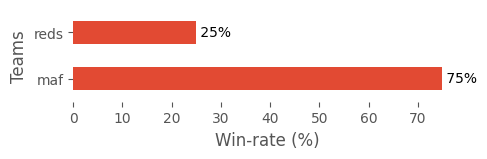

In [79]:
who_wins = df.groupby(['g_time', 'g_who_wins']).agg(wins_count=('g_who_wins', 'count')).reset_index()
who_wins = who_wins.groupby('g_who_wins').agg(wins_by_team=('g_who_wins', 'count')) / len(who_wins) * 100
ax = who_wins.plot(kind='barh', legend=False)
ax.set_frame_on(False)
ax.set_ylabel('Teams')
ax.set_xlabel('Win-rate (%)')
ax.bar_label(ax.containers[0], fmt=' %.0f%%')
set_ax_pixel_size(ax, width=500, height=120)


In [80]:
player_stats = df.groupby('gamer_id').agg(total_games=('gamer_id', 'count'), wins_count=('p_is_winner', 'sum'))
player_stats['win_rate'] = player_stats['wins_count'] / player_stats['total_games'] * 100
player_stats

,total_games,wins_count,win_rate
gamer_id,,,
Gamer #00,35,16,45.714286
Gamer #01,37,14,37.837838
Gamer #02,33,16,48.484848
Gamer #03,37,14,37.837838
Gamer #04,26,7,26.923077
Gamer #05,31,10,32.258065
Gamer #06,25,12,48.000000
Gamer #07,36,12,33.333333
Gamer #08,38,17,44.736842


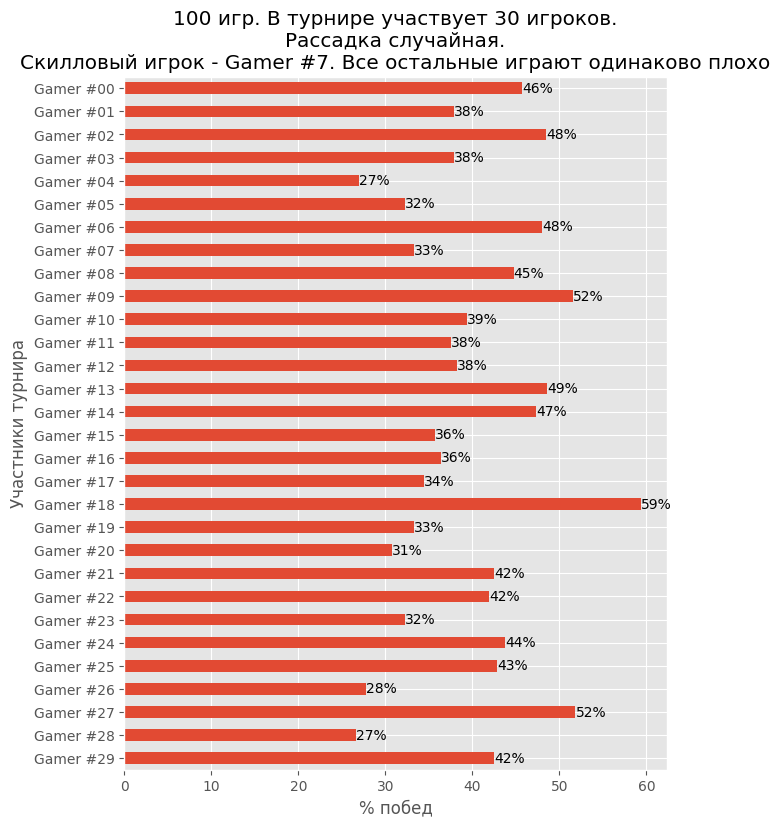

In [81]:
ax = player_stats['win_rate'].plot(kind='barh', legend=False)
set_ax_pixel_size(ax, 700, 900)
ax.bar_label(ax.containers[0], fmt='%.0f%%')
ax.set_ylabel('Участники турнира')
ax.invert_yaxis()
ax.set_xlabel('% побед')
ax.set_title(f'{games_count} игр. В турнире участвует 30 игроков.\nРассадка случайная.\nСкилловый игрок - Gamer #7. Все остальные играют одинаково плохо')
plt.show()

In [82]:
df['correct_votes_cnt'] = (df['votes_for_black'] * ((df['p_role'] == 's') | (df['p_role'] == 'r')).astype('int')) + (df['votes_for_reds'] * (df['p_role'] == 'm').astype('int'))
df

,g_time,g_who_wins,g_total_rounds,g_when_sheriff_killed,p_#,gamer_id,p_role,votes_for_reds,votes_for_black,p_is_winner,correct_votes_cnt
0,2023-05-15 10:47:07.569522,maf,3,2,1,Gamer #00,r,0,1,0,1
1,2023-05-15 10:47:07.569522,maf,3,2,2,Gamer #27,r,1,0,0,0
2,2023-05-15 10:47:07.569522,maf,3,2,3,Gamer #10,m,2,1,1,2
3,2023-05-15 10:47:07.569522,maf,3,2,4,Gamer #13,r,2,1,0,1
4,2023-05-15 10:47:07.569522,maf,3,2,5,Gamer #01,m,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
995,2023-05-15 10:47:07.918804,maf,3,2,6,Gamer #20,r,0,1,0,1
996,2023-05-15 10:47:07.918804,maf,3,2,7,Gamer #19,m,2,1,1,2
997,2023-05-15 10:47:07.918804,maf,3,2,8,Gamer #12,r,2,1,0,1
998,2023-05-15 10:47:07.918804,maf,3,2,9,Gamer #08,r,0,3,0,3


In [83]:
win_and_votes = df.groupby('gamer_id').agg(win_count=('p_is_winner', 'sum'), correct_votes_count=('correct_votes_cnt', 'sum'))
win_and_votes


,win_count,correct_votes_count
gamer_id,,
Gamer #00,16,53
Gamer #01,14,54
Gamer #02,16,49
Gamer #03,14,50
Gamer #04,7,29
Gamer #05,10,37
Gamer #06,12,44
Gamer #07,12,57
Gamer #08,17,44


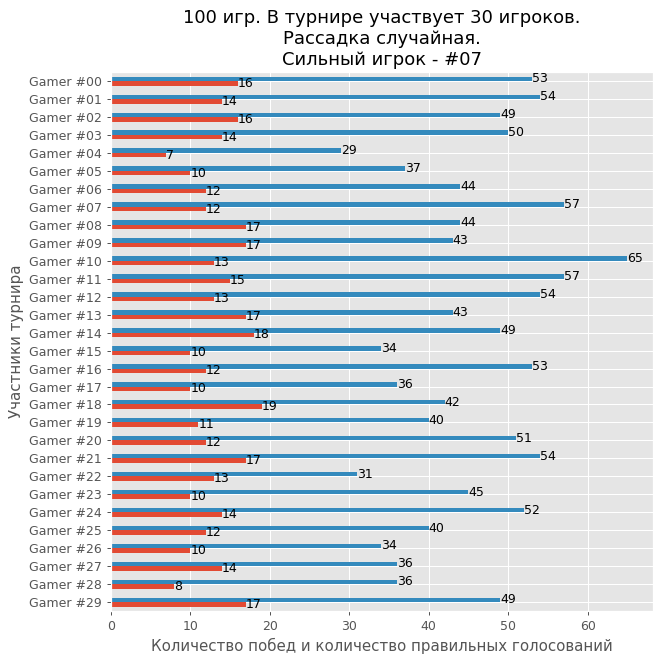

In [84]:
ax = win_and_votes[['win_count', 'correct_votes_count']].sort_index(ascending=False).plot(kind='barh', legend=False)
set_ax_pixel_size(ax, 700, 700, ppi=90)
ax.bar_label(ax.containers[0], fmt='%.0f')
ax.bar_label(ax.containers[1], fmt='%.0f')
ax.set_ylabel('Участники турнира')
ax.set_xlabel('Количество побед и количество правильных голосований')
ax.set_title(f'{games_count} игр. В турнире участвует 30 игроков.\nРассадка случайная.\nСильный игрок - #07')
plt.show()
